# Process 1-point mutational ENM scan
The title of the notebook should be coherent with file name. Namely, file name should be:    
*author's initials_progressive number_title.ipynb*    
For example:    
*EF_01_Data Exploration.ipynb*

## Purpose
State the purpose of the notebook.

## Methodology
Quickly describe assumptions and processing steps.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import
We import all the required Python libraries

In [1]:
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv

import subprocess
import os
from os.path import join as join_paths, basename as get_basename, splitext
import glob
import numpy as np
import itertools
import pandas as pd
from biopandas.pdb import PandasPdb
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

## Change directory
If Jupyter lab sets the root directory in `notebooks`, change directory.

In [2]:
if "notebook" in os.getcwd():
    os.chdir("..")

## Local library import
We import all the required local libraries libraries

In [3]:
# Include local library paths
import sys
sys.path.append("./src") # uncomment and fill to import local libraries

# Import local libraries
import src.utilities as utils
config = utils.read_config()

plt.style.use(config['viz']['default'])

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [4]:
INPUT_DIR="data/external/2020-08-12"


# Data import
We retrieve all the required data for the analysis.

In [5]:
pdb_code = config['pdb']['id']

# Get paths
data_paths = sorted(glob.glob(os.path.join(INPUT_DIR, "*.1point.eigvals.csv")))

# Load data
data_1point = {int(get_basename(path).split(".")[0]) : utils.read_textfile(path) for path in data_paths}

# Data processing
Put here the core of the notebook. Feel free to further split this section into subsections.

In [6]:
def get_vars(data):
    """ Extracts residue numbers, number of modes and k coeffiecnts from
        1-point mutational ENM scan eigenvalue results.
    """
    # Residue numbers
    res_nums = np.fromstring(data[0], sep=",", dtype=int)

    data = data[1:] # Remove residue number line

    # Mode numbers
    if data[0][0] != "#":
        print("Check input data.")
    else:
        i = 0
        # First line: spring strenght row, e.g. #0.25
        while(data[i+1][0] != "#"):
            i += 1
        # Assume that mode numbers start form 7-th mode
        # fist non-tivial mode and the number is the same
        # for all ENM simulation results
        no_modes= i

    mode_nums = np.arange(7,no_modes+7)

    # k coefficients
    k_coeffs = data[::no_modes+1]
    x = []
    for line in k_coeffs:
        clean_line = line.replace("#","").split(',')
        k_coeff = set(clean_line)
        if len(k_coeff) != 1:
            print("Check spring strength values.")
            return None
        x.append(float(k_coeff.pop()))
    k_coeffs = sorted(x)

    return res_nums, mode_nums, k_coeffs

# Get 1-point scan variables form a single file
res_nums, mode_nums, k_coeffs = get_vars(data_1point[0])
# Import eigenvalues
evals_arrays = {key : np.loadtxt(value[1:], delimiter=",", comments="#", dtype=np.dtype(float)) for key, value in data_1point.items()}

NameError: name 'input_data' is not defined

In [ ]:
diss_const_1_array = evals_arrays[1] / evals_arrays[0]
diss_const_2_array = evals_arrays[2] / evals_arrays[1]
coop_array = (evals_arrays[0] * evals_arrays[2]) / (evals_arrays[1] ** 2)
evals_log_arrays = {key :  np.log(value) for key, value in evals_arrays.items()}

In [ ]:
def array_to_dict(data, res_nums, k_coeffs):
    no_splits = len(k_coeffs)
    # Dictionary strucutre: diction[residue_number][k_coeff]
    diction = {}
    for res_idx, res_num in enumerate(res_nums):
        # Separte each mutant eigenvalies for a given residue number
        split_vals = np.split(data[:, res_idx], no_splits)
        # Save spring coefficnts as key and  eigenvalues as value
        diction[res_num] = {k_coeffs[k_idx]: data for k_idx, data in enumerate(split_vals)}

    return diction

eigenval_0_dict = array_to_dict(evals_log_arrays[0], res_nums, k_coeffs)
eigenval_1_dict = array_to_dict(evals_log_arrays[1], res_nums, k_coeffs)
eigenval_2_dict = array_to_dict(evals_log_arrays[2], res_nums, k_coeffs)

diss_const_1_dict = array_to_dict(diss_const_1_array, res_nums, k_coeffs)

coop_dict = array_to_dict(coop_array, res_nums, k_coeffs)

In [ ]:
def dict_to_df(data, mode_cutoff, cumsum=False, cumprod=False): 
    # Extract nested key values
    if cumsum and cumprod:
        print("Choose only one summing option!")
        return None

    res_nums = list(data.keys())
    k_coeffs = list(data[res_nums[0]].keys())

    df = pd.DataFrame(index=k_coeffs, columns=res_nums)
    df.index.name = "k_coeff"
    df.columns.name = "residue_number"

    for res_num in res_nums:
        for k_coeff in k_coeffs:
            if cumsum:
                value = np.cumsum(data[res_num][k_coeff])[mode_cutoff-1]
            elif cumprod:
                value = np.cumprod(data[res_num][k_coeff])[mode_cutoff-1]
            else:
                value = data[res_num][k_coeff][mode_cutoff-1]
            
            df.loc[k_coeff, res_num] = value

    return df.astype(float)

eigenval_0_dfs = {mode_cutoff: dict_to_df(eigenval_0_dict, mode_cutoff, cumsum=True) \
    for mode_cutoff in [25, 50, 75, 100]}
eigenval_1_dfs = {mode_cutoff: dict_to_df(eigenval_1_dict, mode_cutoff, cumsum=True) \
    for mode_cutoff in [25, 50, 75, 100]}
eigenval_2_dfs = {mode_cutoff: dict_to_df(eigenval_2_dict, mode_cutoff, cumsum=True) \
    for mode_cutoff in [25, 50, 75, 100]}

diss_const_1_dfs = {mode_cutoff: dict_to_df(diss_const_1_dict, mode_cutoff, cumprod=True) \
    for mode_cutoff in [25, 50, 75, 100]}

coop_dfs = {mode_cutoff: dict_to_df(coop_dict, mode_cutoff, cumprod=True) \
    for mode_cutoff in [25, 50, 75, 100]}

# Plot data

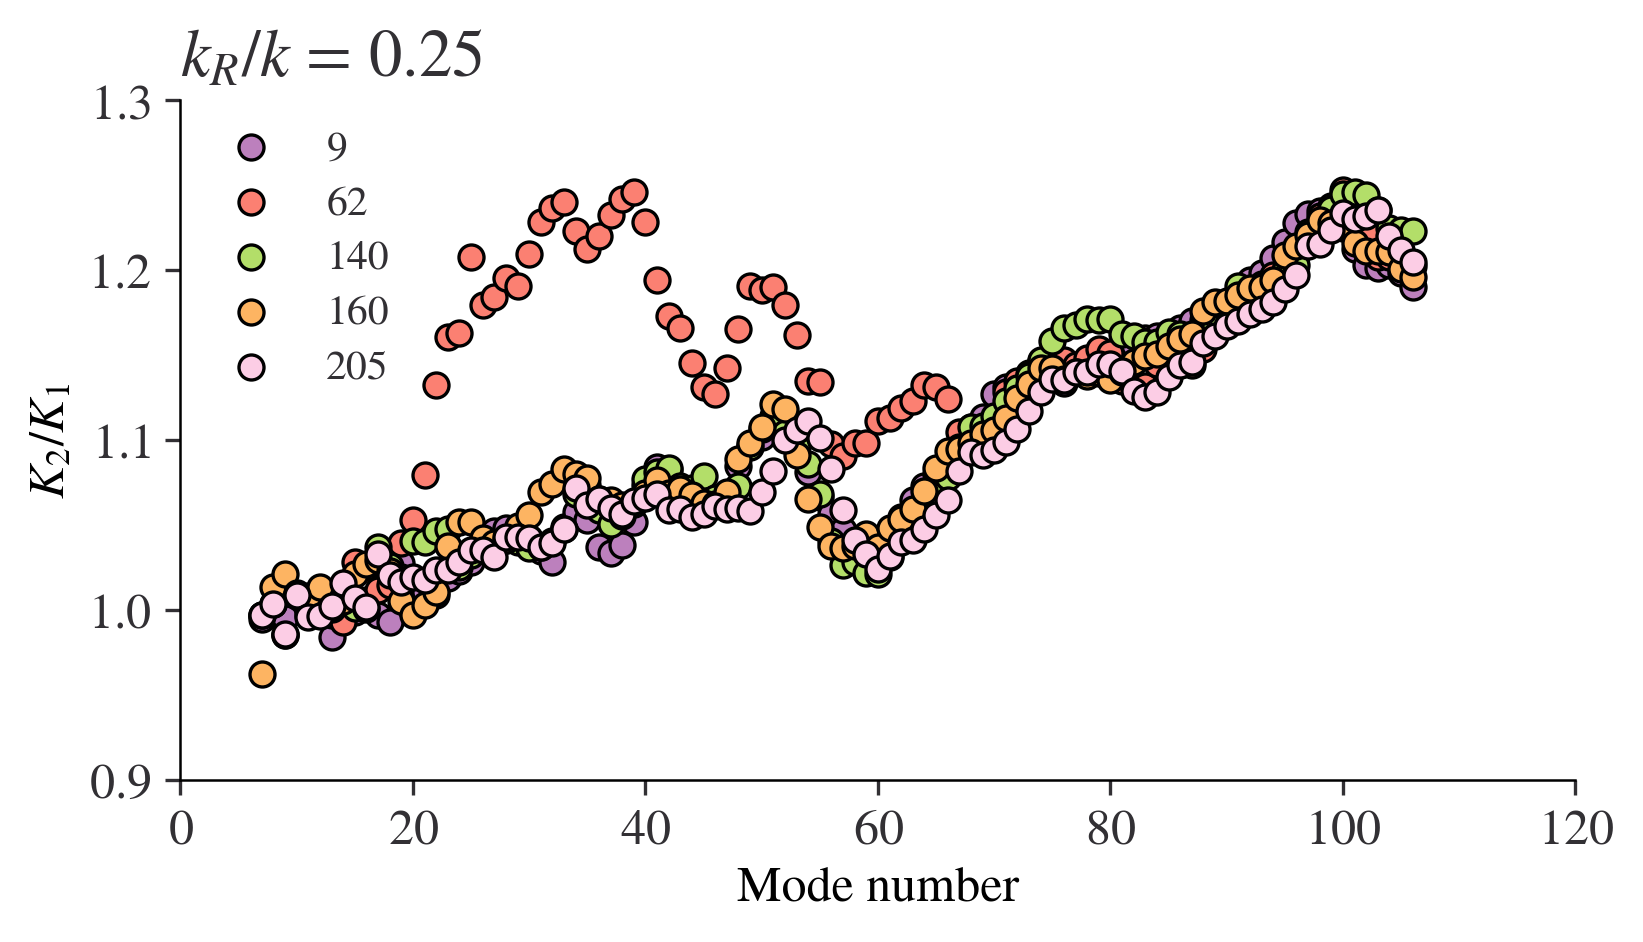

In [ ]:
k_coeff = 0.25
cumval = True

fig, ax = plt.subplots()
for res_num in [9, 62, 140, 160, 205]:
    plot_data = coop_dict[res_num][k_coeff]
    if cumval:
        ax.scatter(mode_nums, np.cumprod(plot_data), label=res_num)
    else:
        ax.scatter(mode_nums, plot_data, label=k_coeff)

ax.set_ylabel("$K_{2}/K_{1}$")
ax.set_xlabel("Mode number")
ax.set_title("$k_R/k$ = {}".format(k_coeff))
ax.legend()
plt.show()

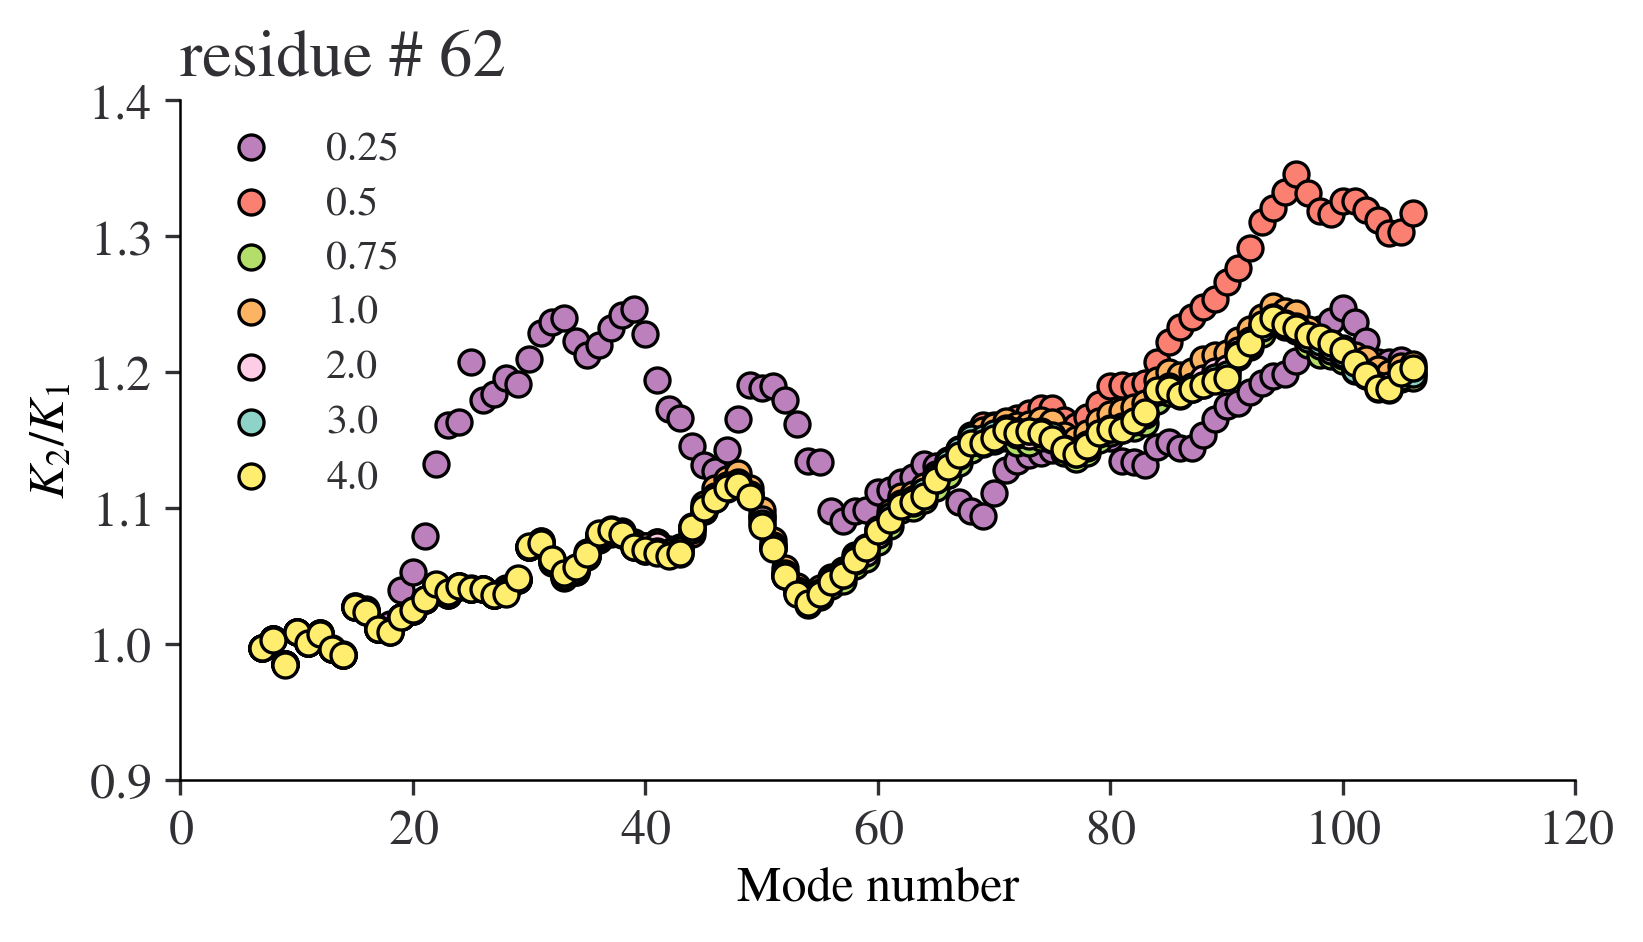

In [ ]:
res_num = 62
cumval = True

fig, ax = plt.subplots()
for k_coeff in k_coeffs[::4]:
    plot_data = coop_dict[res_num][k_coeff]
    if cumval:
        ax.scatter(mode_nums, np.cumprod(plot_data), label=k_coeff)
    else:
        ax.scatter(mode_nums, plot_data, label=k_coeff)

ax.set_ylabel("$K_{2}/K_{1}$")
ax.set_xlabel("Mode number")
ax.set_title("residue # {}".format(res_num))
ax.legend()
plt.show()

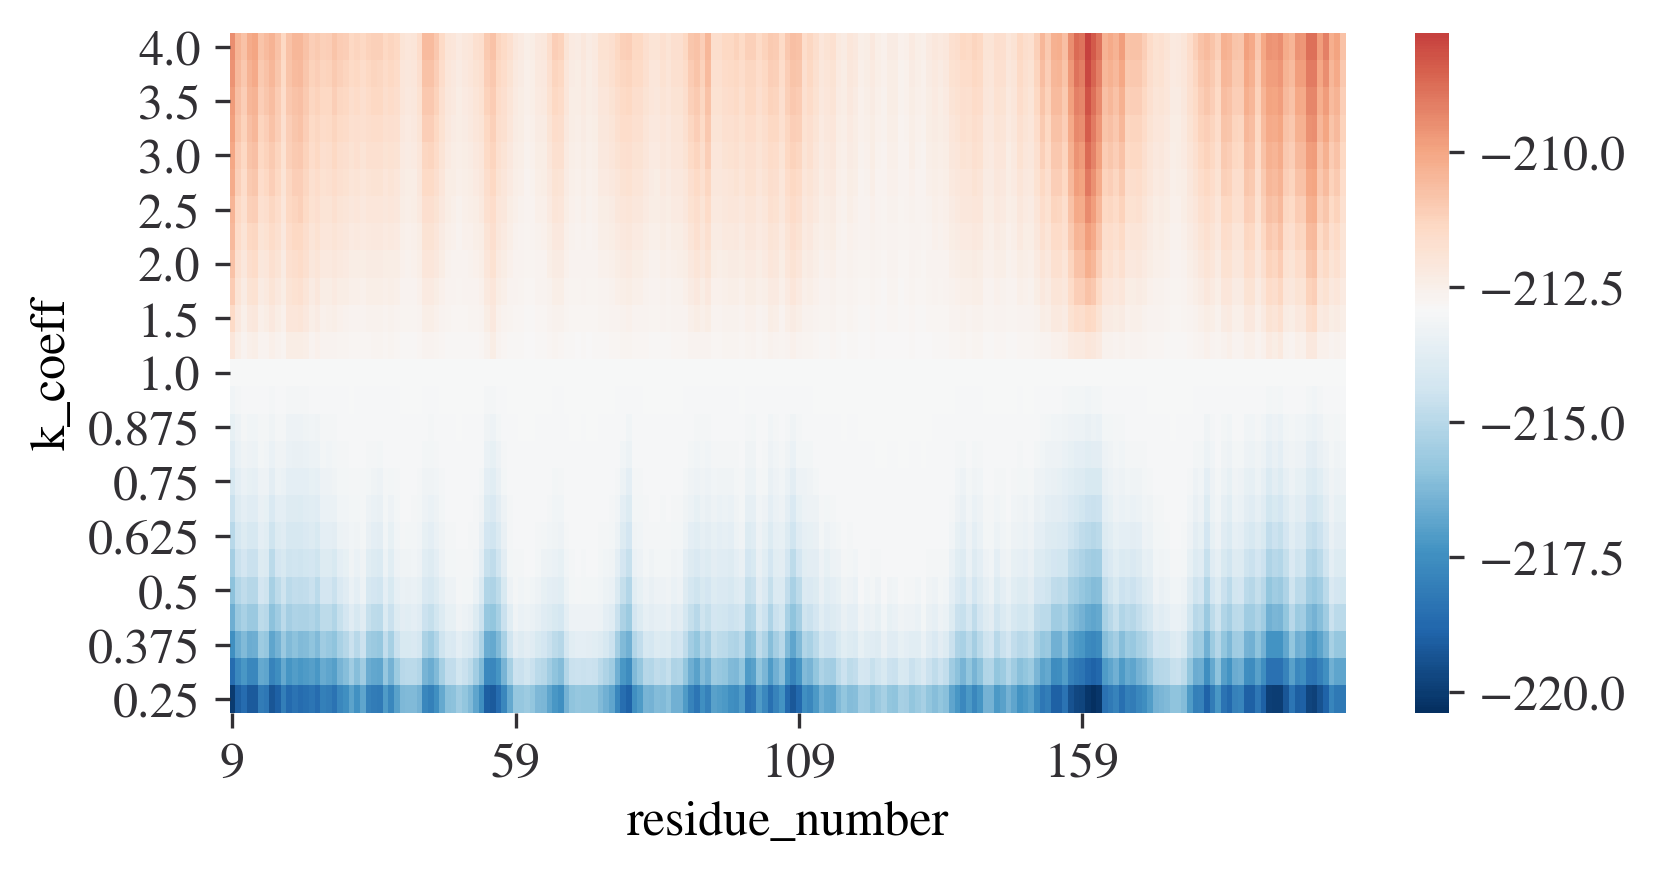

In [ ]:
plot_data = eigenval_0_dfs[100]
fig, ax = plt.subplots()
sns.heatmap(plot_data, center=plot_data.loc[1.00].iloc[0], cmap = plt.cm.RdBu_r, xticklabels = 50, 
                     ax=ax)
ax.invert_yaxis()

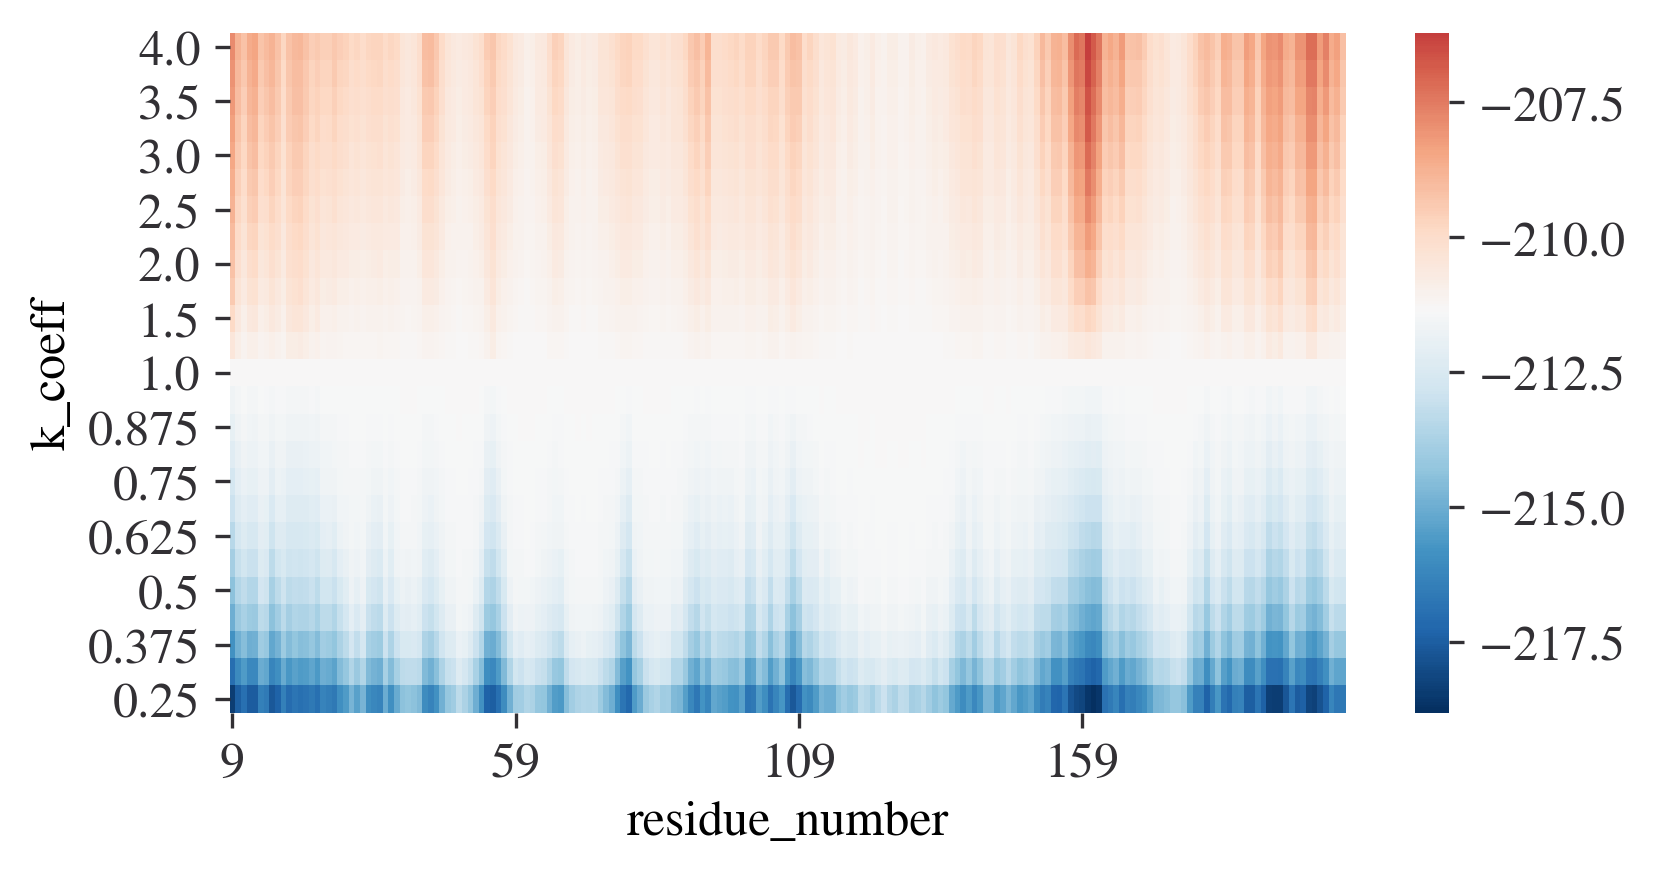

In [ ]:
plot_data = eigenval_1_dfs[100]
fig, ax = plt.subplots()
sns.heatmap(plot_data, center=plot_data.loc[1.00].iloc[0], cmap = plt.cm.RdBu_r, xticklabels = 50, 
                     ax=ax)
ax.invert_yaxis()

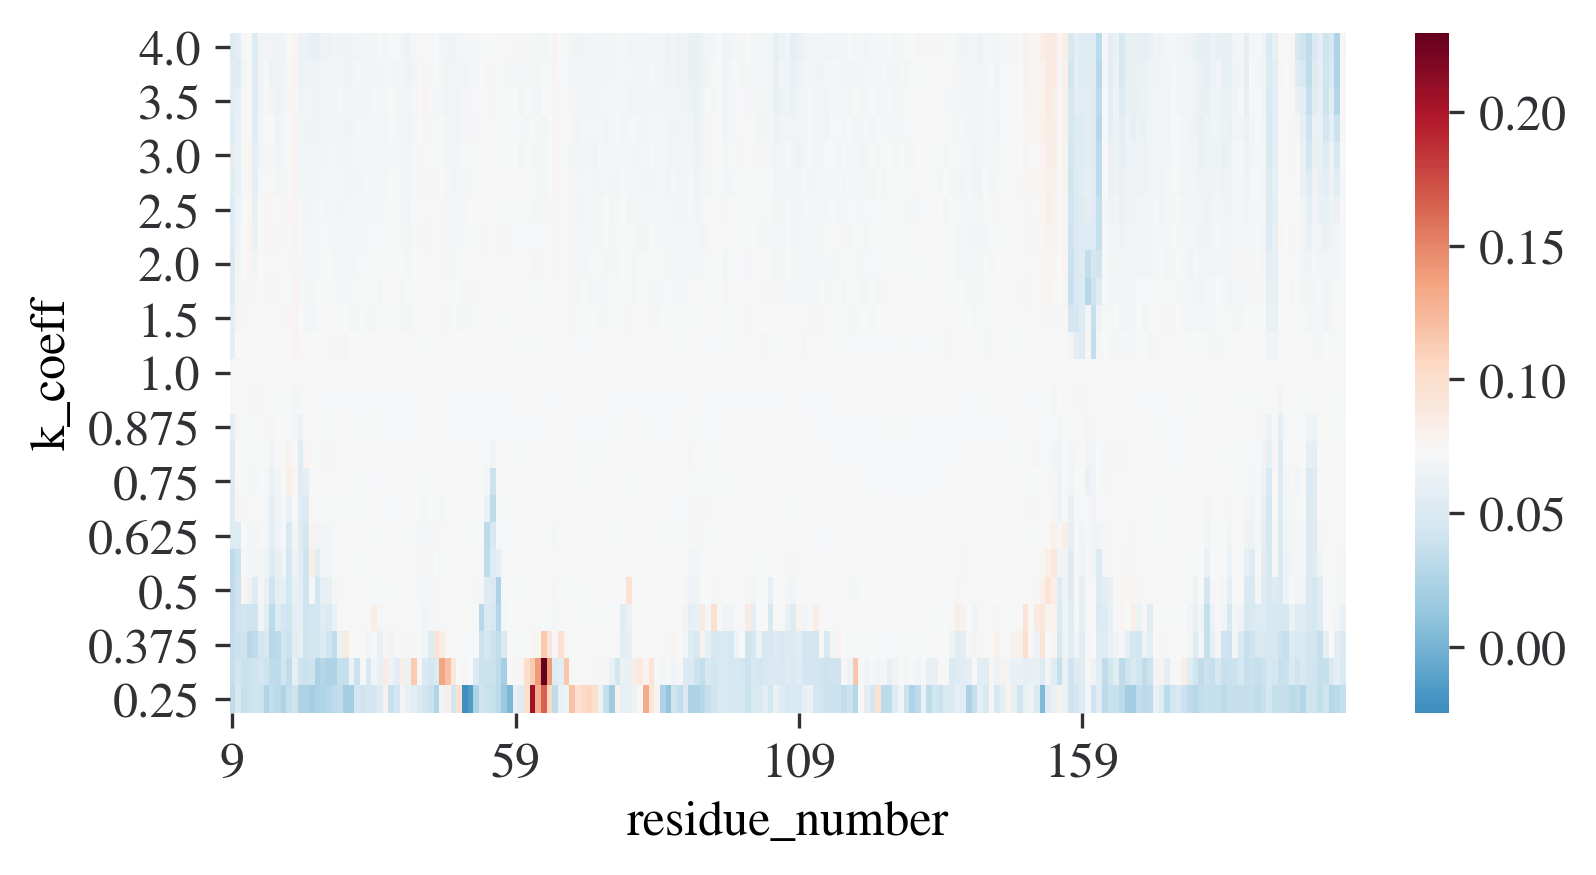

In [ ]:
mode_cutoff = 25
plot_data = (eigenval_2_dfs[mode_cutoff] + eigenval_0_dfs[mode_cutoff]) - (2 * eigenval_1_dfs[mode_cutoff])
type(plot_data)
fig, ax = plt.subplots()
sns.heatmap(plot_data, center=plot_data.loc[1.00].iloc[0], cmap = plt.cm.RdBu_r, xticklabels = 50, 
                     ax=ax)
ax.invert_yaxis()

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2